In [1]:
import numpy as np               
import matplotlib.pyplot as plt  
import pandas as pd
from sklearn import tree
from sklearn import ensemble
from sklearn import datasets 

# 決定木

In [2]:
d = datasets.load_wine()              # wineデータ読込み
dt = tree.DecisionTreeClassifier()    # 決定木
dt.fit(d.data, d.target)              # フィッティング
1-dt.score(d.data,d.target)           # トレーニング誤差

0.0

In [3]:
dt.set_params(max_depth=3)            # 木の深さの最大値を設定
dt.fit(d.data, d.target)              # フィッティング
1-dt.score(d.data,d.target)           # トレーニング誤差

0.022471910112359605

In [4]:
import graphviz            # graphviz.Source を使う
# graphvizで決定木を描画
graph = graphviz.Source(tree.export_graphviz(dt,out_file=None))
# graph.render("DTplot")     # 図をファイルに出力

# バギング

In [5]:
# 1,2,3,4,5 の復元抽出(リサンプリング)
np.random.choice(5,5)

array([3, 1, 3, 2, 0])

In [6]:
# 0，1,2,3,4 の非復元抽出
np.random.choice(5,5,replace=False)

array([3, 0, 2, 4, 1])

In [7]:
d = datasets.load_iris()                 # データ読込み
i = np.random.choice(d.data.shape[0],100,replace=False)
ti = np.delete(np.arange(d.data.shape[0]),i)
x = d.data[i,:];  y = d.target[i]        # トレーニングデータ
tx = d.data[ti,:]; ty = d.target[ti]     # テストデータ
ba = ensemble.BaggingClassifier(n_estimators=100)
ba.fit(x,y)                         # バギング(B=100)
1-ba.score(tx,ty)                   # テスト誤差

0.040000000000000036

In [8]:
dt = tree.DecisionTreeClassifier()  # 単独の決定木を学習
dt.fit(x,y)
1-dt.score(tx,ty)                   # テスト誤差

0.040000000000000036

# ランダム・フォレスト

In [10]:
d  = pd.read_csv('data/stagec.csv').values   # データ読込み
xa = np.array(d[:,:6]).astype('float'); ya = d[:,7]
i = ~np.isnan(xa).any(axis=1); xa = xa[i,:]; ya = ya[i] # nan 除去
x = xa[:100,:];   y = ya[:100]          # トレーニングデータ
tx = xa[100:,:]; ty = ya[100:]          # テストデータ
# ランダムフォレスト：木の数 10
rf = ensemble.RandomForestClassifier(n_estimators=10)  
rf.fit(x,y)
1-rf.score(tx,ty)    # テスト誤差

0.054054054054054057

In [11]:
# ランダムフォレスト：木の数 1000
rf.set_params(n_estimators=1000)
rf.fit(x,y)
1-rf.score(tx,ty)    # テスト誤差

0.054054054054054057

In [12]:
dt = tree.DecisionTreeClassifier()      #  決定木
dt.fit(x,y)
1-dt.score(tx,ty)    # テスト誤差

0.054054054054054057

In [13]:
ba = ensemble.BaggingClassifier(n_estimators=10)  # バギング(B=10)
ba.fit(x,y)
1-ba.score(tx,ty)    # テスト誤差

0.027027027027026973

# ブースティング

In [15]:
n = 4000                               # トレーニングデータ数
d = pd.read_csv('data/soldat.csv').values;  # データ読込み
d=np.delete(d,70,1)                    # nanを除去
i  = np.random.choice(len(d),n,replace=False)  
ti = np.delete(np.arange(len(d)), i)           
x  = d[i,:71];   y = d[i,71]             # トレーニングデータ
tx = d[ti,:71]; ty = d[ti,71]            # テストデータ
T = 1000                                 # ブースティング：ラウンド数
bl = tree.DecisionTreeClassifier(max_depth=1)               # 決定株
# 決定株でアダブーストを実行
ab = ensemble.AdaBoostClassifier(base_estimator=bl, n_estimators=T)
ab.fit(x,y)                                # フィッティング
# 各ラウンドの誤差
ada_tr_err = np.zeros((T,))            
for i, score in enumerate(ab.staged_score(x,y)): 
    ada_tr_err[i] = 1-score                     # トレーニング誤差
ada_te_err = np.zeros((T,))            
for i, score in enumerate(ab.staged_score(tx,ty)): 
    ada_te_err[i] = 1-score                     # テスト誤差

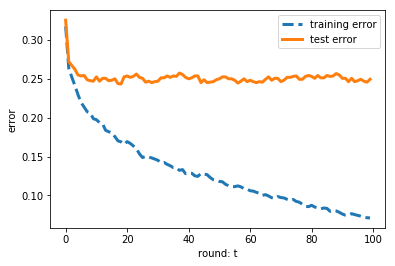

In [16]:
plt.xlabel('round: t')
plt.ylabel('error')
plt.plot(ada_tr_err[::10],label='training error',linestyle='dashed',lw=3)
plt.plot(ada_te_err[::10],label='test error',    linestyle='solid', lw=3)
plt.legend()
plt.show()

In [20]:
import xgboost as xgb          # xgboostを使う
# データ読込み
n = 4000
d = pd.read_csv('data/soldat.csv').values; d = np.delete(d,70,1)
i  = np.random.choice(len(d),n,replace=False)
ti = np.delete(np.arange(len(d)), i)
x  = d[i,:71];   y = d[i,71]
tx = d[ti,:71]; ty = d[ti,71]
T = 1000                       # ラウンド数 1000
xg = xgb.XGBClassifier(n_estimators=T, max_depth=1, objective='binary:logistic')

xg.fit(x,y)                    # フィッティング
1-xg.score(tx,ty)              # テスト誤差

0.24586143470263644

In [21]:
xg = xgb.XGBClassifier(n_estimators=1000, max_depth=1, objective= 'binary:logistic')
cvx = x[:3500,:]; cvy = y[:3500];       # トレーニングデータ
eval_set = [(x[3500:,:], y[3500:])]    # 検証用のデータ
xg.fit(cvx, cvy, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set,verbose=True) # verboseを設定：途中経過をプリント

[0]	validation_0-logloss:0.672839
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.656299
[2]	validation_0-logloss:0.642599
[3]	validation_0-logloss:0.630719
[4]	validation_0-logloss:0.622753
[5]	validation_0-logloss:0.613857
[6]	validation_0-logloss:0.606615
[7]	validation_0-logloss:0.598363
[8]	validation_0-logloss:0.593934
[9]	validation_0-logloss:0.587321
[10]	validation_0-logloss:0.582386
[11]	validation_0-logloss:0.57844
[12]	validation_0-logloss:0.57515
[13]	validation_0-logloss:0.57327
[14]	validation_0-logloss:0.56893
[15]	validation_0-logloss:0.566765
[16]	validation_0-logloss:0.565534
[17]	validation_0-logloss:0.563231
[18]	validation_0-logloss:0.560336
[19]	validation_0-logloss:0.558584
[20]	validation_0-logloss:0.557643
[21]	validation_0-logloss:0.555613
[22]	validation_0-logloss:0.554704
[23]	validation_0-logloss:0.553054
[24]	validation_0-logloss:0.551525
[25]	validation_0-logloss:0.549957
[26]	validation_0-logloss:0.54862
[2

[230]	validation_0-logloss:0.505769
[231]	validation_0-logloss:0.50557
[232]	validation_0-logloss:0.505526
[233]	validation_0-logloss:0.50601
[234]	validation_0-logloss:0.506252
[235]	validation_0-logloss:0.506082
[236]	validation_0-logloss:0.505896
[237]	validation_0-logloss:0.506196
[238]	validation_0-logloss:0.505828
[239]	validation_0-logloss:0.505795
[240]	validation_0-logloss:0.505586
[241]	validation_0-logloss:0.505774
[242]	validation_0-logloss:0.505763
Stopping. Best iteration:
[232]	validation_0-logloss:0.505526



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [22]:
xg.best_iteration          # 最適なラウンド数

232

In [23]:
1-xg.score(tx,ty)          # テスト誤差

0.25751072961373389

In [24]:
xg.predict_proba(tx)      # 予測点における各ラベルの条件付き確率

array([[ 0.78645766,  0.21354231],
       [ 0.78047788,  0.21952213],
       [ 0.77795959,  0.2220404 ],
       ..., 
       [ 0.84463835,  0.15536164],
       [ 0.84458882,  0.15541118],
       [ 0.46995419,  0.53004581]], dtype=float32)